In [1]:
import pandas as pd
import os
import zipfile
import seaborn as sns
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import random

In [2]:
pd.set_option('display.max_columns',200)
pd.set_option('display.max_rows',200)
pd.set_option('display.max_colwidth', 500)

# Read in Data

In [3]:
base_path = '../../data/'

In [4]:
acs_data_dict = pd.read_csv(os.path.join(base_path, 'acs5_data_dictionary.csv'))
acs = pd.read_excel(os.path.join(base_path, 'national_acs5-2018_census.xlsx'))

In [5]:
zf = zipfile.ZipFile(os.path.join(base_path,'brownfields_data_with_county_geoid.zip'), 'r')
brownfields = pd.read_csv(zf.open('brownfields_data_with_county_geoid.csv'))

/home/helloannietran/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (18,19,20,21,22,23,43,44,46,48,53,57,61,62,64,65,67,68,69,74,76,77,78,86,87,89,98) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [6]:
brownfields.shape

(78527, 150)

# Build dataset

- Focus on sites where Ready For Reuse Ind == Y

In [8]:
# filter to sites where Ready For Reuse Ind == Y since clean up there was finished or not needed
bf_ready_for_reuse = brownfields[brownfields['Ready For Reuse Ind']=='Y'].reset_index(drop=True).copy()


# adjust values to be consistent in categorical cols
bf_ready_for_reuse.loc[bf_ready_for_reuse['Cleanup Required']=='u', 'Cleanup Required'] = 'U'
bf_ready_for_reuse.loc[bf_ready_for_reuse['Did Ownership Change']=='n', 'Did Ownership Change'] = 'N'

# created a column to flag if grant was funded by EPA
bf_ready_for_reuse['Funded by EPA'] = 'N'
bf_ready_for_reuse.loc[bf_ready_for_reuse['Source of Assessment Funding'].fillna('N').str.contains('EPA'), 'Funded by EPA'] = 'Y'
bf_ready_for_reuse.loc[bf_ready_for_reuse['Source of Assessment Funding'].isnull(), 'Funded by EPA'] = np.nan

# filter to sites where clean up cost is not null
nonnull_cost = bf_ready_for_reuse[~bf_ready_for_reuse['Amount of Cleanup Funding'].isnull()]['ACRES Property ID']
bf_ready_for_reuse = bf_ready_for_reuse[bf_ready_for_reuse['ACRES Property ID'].isin(nonnull_cost)]

# group all the epa fundings together
bf_ready_for_reuse.loc[bf_ready_for_reuse['Source of Cleanup Funding'].fillna('N').str.contains('EPA'),'Source of Cleanup Funding'] = 'EPA'
bf_ready_for_reuse.loc[bf_ready_for_reuse['Source of Assessment Funding'].fillna('N').str.contains('EPA'),'Source of Assessment Funding'] = 'EPA'
bf_ready_for_reuse.loc[bf_ready_for_reuse['Src of Redev Funding'].fillna('N').str.contains('EPA'),'Src of Redev Funding'] = 'EPA'

In [194]:
# roll records up to site level for easier cost analysis
# counting sources of funding by the source of funding columns could be slightly off since
    # there are missing values in that column. The unknowns might be from different sources

# clean up funding
cols = ['ACRES Property ID','Source of Cleanup Funding','Amount of Cleanup Funding']
clean_up_cost_roll_up = bf_ready_for_reuse[cols].copy()
clean_up_cost_roll_up = clean_up_cost_roll_up[~clean_up_cost_roll_up['Amount of Cleanup Funding'].isnull()]
clean_up_cost_roll_up['Source of Cleanup Funding'] = clean_up_cost_roll_up['Source of Cleanup Funding'].fillna('Unknown')
clean_up_cost_roll_up = clean_up_cost_roll_up.drop_duplicates()
# count sources of funding and sum of funding for each site
clean_up_cost_roll_up = clean_up_cost_roll_up.groupby('ACRES Property ID').agg({'Source of Cleanup Funding':'nunique',
                                                        'Amount of Cleanup Funding':'sum'}).reset_index()


# assessment funding
cols = ['ACRES Property ID','Source of Assessment Funding','Amt of Assessment Funding']
assessment_cost_roll_up = bf_ready_for_reuse[cols].copy()
assessment_cost_roll_up = assessment_cost_roll_up[~assessment_cost_roll_up['Amt of Assessment Funding'].isnull()]
assessment_cost_roll_up['Source of Assessment Funding'] = assessment_cost_roll_up['Source of Assessment Funding'].fillna('Unknown')
assessment_cost_roll_up = assessment_cost_roll_up.drop_duplicates()
# count sources of funding and sum of funding for each site
assessment_cost_roll_up = assessment_cost_roll_up.groupby('ACRES Property ID').agg({'Source of Assessment Funding':'nunique',
                                                        'Amt of Assessment Funding':'sum'}).reset_index()


#reve funding
cols = ['ACRES Property ID','Src of Redev Funding','Amount of Redev Funding']
redev_cost_roll_up = bf_ready_for_reuse[cols].copy()
redev_cost_roll_up = redev_cost_roll_up[~redev_cost_roll_up['Amount of Redev Funding'].isnull()]
redev_cost_roll_up['Src of Redev Funding'] = redev_cost_roll_up['Src of Redev Funding'].fillna('Unknown')
redev_cost_roll_up = redev_cost_roll_up.drop_duplicates()
# count sources of funding and sum of funding for each site
redev_cost_roll_up = redev_cost_roll_up.groupby('ACRES Property ID').agg({'Src of Redev Funding':'nunique',
                                                                          'Amount of Redev Funding':'sum'}).reset_index()


# combine to funding df
funding_df = clean_up_cost_roll_up.merge(assessment_cost_roll_up, how='outer')
funding_df = funding_df.merge(redev_cost_roll_up, how='outer')
# handle nulls
funding_df['Source of Assessment Funding'] = funding_df['Source of Assessment Funding'].fillna('No Assessment')
funding_df['Amt of Assessment Funding'] = funding_df['Amt of Assessment Funding'].fillna(0)
funding_df['Src of Redev Funding'] = funding_df['Src of Redev Funding'].fillna('No Redev')
funding_df['Amount of Redev Funding'] = funding_df['Amount of Redev Funding'].fillna(0)

funding_df['Overall Cleanup Cost'] = funding_df['Amt of Assessment Funding'] + funding_df['Amount of Cleanup Funding']

# count number of grants
#grant_cnts = funding_df.groupby('ACRES Property ID')['Grant ID'].nunique().reset_index()
#funding_df = funding_df.merge(grant_cnts, how='left')


# Type of Brownfields Grant
# shouldn't count TBA (to be announced?)
# BCRLF is a loan which should be treated separately from other grants


#Acreage and Greenspace
acr_greens = bf_ready_for_reuse[['ACRES Property ID','Acreage and Greenspace Created']].copy()
acr_greens['Acreage and Greenspace Created'] = acr_greens['Acreage and Greenspace Created'].fillna(0)
acr_greens = acr_greens.drop_duplicates()
acr_greens = acr_greens.groupby('ACRES Property ID')['Acreage and Greenspace Created'].sum().reset_index()
funding_df = funding_df.merge(acr_greens, how='left')


# add in characteristics of the property
property_features = ['Property City', 'Property  State', 'Property Size','Property Latitude',
                     'Property Longitude', 'Past Use: Greenspace (arces)','Past Use: Residential (arces)',
                     'Past Use: Commercial (arces)','Past Use: Industrial (arces)',
                     'Ownership Entity','Future Use-Greenspace','Future Use-Residential',
                     'Future Use-Commercial', 'Future Use-Industrial',
                     'Photographs are available', 'Video is available'
                    ]

property_df = bf_ready_for_reuse[['ACRES Property ID'] + property_features].drop_duplicates()
property_df['Property Longitude'] = property_df['Property Longitude'].astype(float)
property_df['Property Longitude'] = property_df['Property Longitude'].round(4)
property_df['Property Latitude'] = property_df['Property Latitude'].astype(float)
property_df['Property Latitude'] = property_df['Property Latitude'].round(4)
property_df = property_df.drop_duplicates()
arce_cols = [c for c in property_df if 'Past Use' in c or 'Future Use' in c]
for c in arce_cols:
    property_df[c] = property_df[c].fillna(0)
property_df['Photographs are available'] = property_df['Photographs are available'].fillna('N')
property_df['Video is available'] = property_df['Video is available'].fillna('N')

funding_df = funding_df.merge(property_df, how='left')
# fill null ownership entity with Government for now
funding_df['Ownership Entity'] = funding_df['Ownership Entity'].fillna('Government')


# add in census data
# census_features = ['2010 # Below Poverty','2010 % Below Poverty','2010 Median Income',
#                    '2010 # Low Income','2010 % Low Income','2010 # Vacant Housing',
#                    '2010 % Vacant Housing','2010 # Unemployed','2010 % Unemployed']

# census_df = bf_ready_for_reuse[['ACRES Property ID'] + census_features].drop_duplicates()
# funding_df = funding_df.merge(census_df, how='left')



# tribal program
tribal_df = bf_ready_for_reuse[['ACRES Property ID', 'Enrollment ST/Tribal Prg']].copy().drop_duplicates()
tribal_df['Tribal Prg Enrolled'] = 'N'
tribal_df.loc[~tribal_df['Enrollment ST/Tribal Prg'].isnull(),'Tribal Prg Enrolled'] = 'Y'
funding_df = funding_df.merge(tribal_df[['ACRES Property ID','Tribal Prg Enrolled']], how='left')



# contaminant features
cntmnt_fnd_features = ['Cntmnt Fnd-Arsenic','Cntmnt Fnd-Asbestos','Cntmnt Fnd-Cadmium',
                       'Cntmnt Fnd-Chromium','Cntmnt Fnd-Ctrl Sbstncs','Cntmnt Fnd-Copper',
                       'Cntmnt Fnd-Iron','Cntmnt Fnd-Lead','Cntmnt Fnd-Mercury','Cntmnt Fnd-Nickel',
                       'Cntmnt Fnd-None','Cntmnt Fnd-Other','Cntmnt Fnd-Other Metals',
                       'Cntmnt Fnd-PAHs','Cntmnt Fnd-PCBs','Cntmnt Fnd-Pesticides',
                       'Cntmnt Fnd-Petroleum','Cntmnt Fnd-Selenium','Cntmnt Fnd-SVOCs',
                       'Cntmnt Fnd-Unknown','Cntmnt Fnd-VOCs']


cntmnt_fnd_df = bf_ready_for_reuse[['ACRES Property ID'] + cntmnt_fnd_features].copy().drop_duplicates()
cntmnt_fnd_df = cntmnt_fnd_df.fillna('N')
cntmnt_fnd_df = cntmnt_fnd_df.replace('N',0)
cntmnt_fnd_df = cntmnt_fnd_df.replace('Y',1)

# count of contaminants found
cntmnt_fnd_df['# of Cntmnt Fnd'] = cntmnt_fnd_df[cntmnt_fnd_features].sum(axis=1)
funding_df = funding_df.merge(cntmnt_fnd_df, how='left')



# where contaminants is found
cntmnt_where_features = ['Media Affected-Unknown','Media Affected-Sediments',
                         'Media Affected-Bldg Materials','Media Affected-Soil',
                         'Media Affected-Surface Water','Media Affected-Drnking Water',
                         'Media Affected-Ground Water','Media Affected-Indoor Air',
                         'Media Affected-Air']

cntmnt_where_df = bf_ready_for_reuse[['ACRES Property ID'] + cntmnt_where_features].copy().drop_duplicates()
cntmnt_where_df = cntmnt_where_df.fillna('N')
cntmnt_where_df = cntmnt_where_df.replace('N',0)
cntmnt_where_df = cntmnt_where_df.replace('Y',1)

# count of contaminants found
cntmnt_where_df['# Media Affected'] = cntmnt_where_df[cntmnt_where_features].sum(axis=1)
funding_df = funding_df.merge(cntmnt_where_df, how='left')



# merging in acs data
geoid = bf_ready_for_reuse[['ACRES Property ID','GEOID']].drop_duplicates()
# not sure how to handle the dup geoid, so just take the max for now
# only 6 sites found with this happening
geoid = geoid.groupby('ACRES Property ID')['GEOID'].max().reset_index()
funding_df = funding_df.merge(geoid, how='left')
# only keep raw counts for now
cols = ['GEOID'] + [c for c in acs if 'DP' in c and 'PE' not in c]
estimate_acs = acs[cols].copy()
funding_df = funding_df.merge(estimate_acs, how='left', on='GEOID')
# remove the records where census is null
funding_df = funding_df[~funding_df['DP05_0084E'].isnull()]

In [195]:
# bf_ready_for_reuse['Did Ownership Change'].value_counts(dropna=False)
# bf_ready_for_reuse['Description/History'].iloc[1]

In [196]:
funding_df.shape

(2259, 575)

In [197]:
funding_df.head()

,ACRES Property ID,Source of Cleanup Funding,Amount of Cleanup Funding,Source of Assessment Funding,Amt of Assessment Funding,Src of Redev Funding,Amount of Redev Funding,Overall Cleanup Cost,Acreage and Greenspace Created,Property City,Property State,Property Size,Property Latitude,Property Longitude,Past Use: Greenspace (arces),Past Use: Residential (arces),Past Use: Commercial (arces),Past Use: Industrial (arces),Ownership Entity,Future Use-Greenspace,Future Use-Residential,Future Use-Commercial,Future Use-Industrial,Photographs are available,Video is available,Tribal Prg Enrolled,Cntmnt Fnd-Arsenic,Cntmnt Fnd-Asbestos,Cntmnt Fnd-Cadmium,Cntmnt Fnd-Chromium,Cntmnt Fnd-Ctrl Sbstncs,Cntmnt Fnd-Copper,Cntmnt Fnd-Iron,Cntmnt Fnd-Lead,Cntmnt Fnd-Mercury,Cntmnt Fnd-Nickel,Cntmnt Fnd-None,Cntmnt Fnd-Other,Cntmnt Fnd-Other Metals,Cntmnt Fnd-PAHs,Cntmnt Fnd-PCBs,Cntmnt Fnd-Pesticides,Cntmnt Fnd-Petroleum,Cntmnt Fnd-Selenium,Cntmnt Fnd-SVOCs,Cntmnt Fnd-Unknown,Cntmnt Fnd-VOCs,# of Cntmnt Fnd,Media Affected-Unknown,Media Affected-Sediments,Media Affected-Bldg Materials,Media Affected-Soil,Media Affected-Surface Water,Media Affected-Drnking Water,Media Affected-Ground Water,Media Affected-Indoor Air,Media Affected-Air,# Media Affected,GEOID,DP02_0001E,DP02_0002E,DP02_0003E,DP02_0004E,DP02_0005E,DP02_0006E,DP02_0007E,DP02_0008E,DP02_0009E,DP02_0010E,DP02_0011E,DP02_0012E,DP02_0013E,DP02_0014E,DP02_0015E,DP02_0016E,DP02_0017E,DP02_0018E,DP02_0019E,DP02_0020E,DP02_0021E,DP02_0022E,DP02_0023E,DP02_0024E,DP02_0025E,DP02_0026E,DP02_0027E,DP02_0028E,DP02_0029E,DP02_0030E,DP02_0031E,DP02_0032E,DP02_0033E,DP02_0034E,DP02_0035E,DP02_0036E,DP02_0037E,DP02_0038E,DP02_0039E,DP02_0040E,DP02_0041E,...,DP04_0128E,DP04_0129E,DP04_0130E,DP04_0131E,DP04_0132E,DP04_0133E,DP04_0134E,DP04_0135E,DP04_0136E,DP04_0137E,DP04_0138E,DP04_0139E,DP04_0140E,DP04_0141E,DP04_0142E,DP04_0143E,DP05_0001E,DP05_0002E,DP05_0003E,DP05_0004E,DP05_0005E,DP05_0006E,DP05_0007E,DP05_0008E,DP05_0009E,DP05_0010E,DP05_0011E,DP05_0012E,DP05_0013E,DP05_0014E,DP05_0015E,DP05_0016E,DP05_0017E,DP05_0018E,DP05_0019E,DP05_0020E,DP05_0021E,DP05_0022E,DP05_0023E,DP05_0024E,DP05_0025E,DP05_0026E,DP05_0027E,DP05_0028E,DP05_0029E,DP05_0030E,DP05_0031E,DP05_0032E,DP05_0033E,DP05_0034E,DP05_0035E,DP05_0036E,DP05_0037E,DP05_0038E,DP05_0039E,DP05_0040E,DP05_0041E,DP05_0042E,DP05_0043E,DP05_0044E,DP05_0045E,DP05_0046E,DP05_0047E,DP05_0048E,DP05_0049E,DP05_0050E,DP05_0051E,DP05_0052E,DP05_0053E,DP05_0054E,DP05_0055E,DP05_0056E,DP05_0057E,DP05_0058E,DP05_0059E,DP05_0060E,DP05_0061E,DP05_0062E,DP05_0063E,DP05_0064E,DP05_0065E,DP05_0066E,DP05_0067E,DP05_0068E,DP05_0069E,DP05_0070E,DP05_0071E,DP05_0072E,DP05_0073E,DP05_0074E,DP05_0075E,DP05_0076E,DP05_0077E,DP05_0078E,DP05_0079E,DP05_0080E,DP05_0081E,DP05_0082E,DP05_0083E,DP05_0084E
0,10027,1,104351.0,2,80000.00,No Redev,0.0,184351.00,0.0,Holyoke,MA,1.40,42.2038,-72.5939,0.0,0.0,0.0,1.40,Government,0.00,0.0,0.0,0.0,Y,N,Y,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,4,0,0,0,1,0,0,0,0,0,1,25013.0,179043.0,114896.0,48689.0,73676.0,26389.0,9193.0,3768.0,32027.0,18532.0,64147.0,53478.0,22636.0,55240.0,53919.0,2.54,3.15,454428.0,179043.0,73395.0,143639.0,30475.0,27876.0,13231.0,183480.0,77579.0,79516.0,3380.0,5181.0,17824.0,201730.0,73154.0,78833.0,5371.0,18713.0,25659.0,5537.0,2316.0,32.0,50.0,14.0,80.0,...,27664.0,20615.0,3725.0,847.0,139.0,340.0,885.0,2372.0,66495.0,7857.0,7136.0,6888.0,8086.0,7291.0,29237.0,3610.0,469116.0,226555.0,242561.0,93.4,26426.0,27664.0,29816.0,33599.0,35299.0,61065.0,53708.0,62857.0,33301.0,30152.0,42186.0,21480.0,11563.0,38.9,102903.0,378775.0,366213.0,344185.0,92287.0,75229.0,366213.0,173743.0,192470.0,90.3,75229.0,32011.0,43218.0,74.1,469116.0,456030.0,13086.0,456030.0,380944.0,41166.0,1280.0,0.0,73.0,0.0,21.0,11052.0,1623.0,2664.0,653.0,214.0,751.0,1849.0,3298.0,87.0,6.0,0.0,12.0,69.0,21501.0,13086.0,5298.0,1454.0,1820.0,607.0,469116.0,391711.0,48942.0,3843.0,13597.0,787.0,24232.0,469116.0,115479.0,3624.0,98738.0,864.0,12253.0,3

# Preprocess

In [198]:
# ignore features that might correlated with overall cost to avoid leakage
keep_features = ['Video is available','Photographs are available',
                'Future Use-Commercial' ,'Future Use-Residential','Future Use-Greenspace' ,
                'Future Use-Industrial',
                'Past Use: Commercial (arces)','Past Use: Residential (arces)',
                'Past Use: Greenspace (arces)' ,'Past Use: Industrial (arces)', 
                'Property Size',  'Acreage and Greenspace Created',
                'Tribal Prg Enrolled','Ownership Entity']
keep_features = keep_features + [c for c in funding_df if 'Cntmnt' in c or 'Media Affected'in c]
keep_features = keep_features + [c for c in funding_df if 'DP' in c]
target = 'Overall Cleanup Cost'

model_df = funding_df[keep_features+[target]].copy()

# transform categorical variables
cat_mapping = {"Video is available":{"N": 0, "Y": 1},
               "Photographs are available":{"N": 0, "Y": 1},
               "Tribal Prg Enrolled":{"N": 0, "Y": 1},
               "Ownership Entity":{"Government": 0, "Private": 1}}
model_df = model_df.replace(cat_mapping)

# log transformation
log_features = [c for c in model_df if 'Future Use' in c or 'Past Use' in c]
log_features = log_features + ['# of Cntmnt Fnd', '# Media Affected', target]
log_features = log_features + [c for c in model_df if 'DP' in c]

for f in log_features:
    model_df[f + ' Log'] = np.log(model_df[f]+0.01)
    model_df.drop(f, axis=1, inplace=True)

/home/helloannietran/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [199]:
# log is 0 when value is very large
nulls = model_df.isnull().sum().sort_values(ascending=False)
drop_f = nulls[nulls>2000].index

model_df.drop(drop_f, axis=1, inplace=True)
model_df = model_df.fillna(np.log(0.01))

model_df = model_df.reset_index(drop=True)

In [200]:
# # apply pca to acs data

# def apply_pca(pca, feature_df):
    
#     projected_df = pca.transform(feature_df)
#     projected_df = pd.DataFrame(projected_df)
#     projected_df.columns = ['DP_component_' + str(n) for n in projected_df.columns]
    
#     return projected_df


# # Keeping 95% variance
# variance = 0.95
# # gene features
# DP_features = [c for c in model_df.columns if 'DP' in c]
# dp_pca = PCA(variance).fit(model_df[DP_features])
# print(f'Number of components for acs features to keep {int(variance*100)}% variance: ', dp_pca.n_components_)

# transformed_df = apply_pca(dp_pca, model_df[DP_features])
# model_df.drop(DP_features, axis=1, inplace=True)
# model_df = pd.concat([model_df, transformed_df], axis=1)

In [201]:
# drop since it's all 0
del model_df['Cntmnt Fnd-Unknown']

# EDA

In [15]:
# none of the census features in brownfield seem to correlate with overall clean up cost
#plt.scatter(np.log(funding_df['2010 Median Income']), np.log(funding_df['Overall Cleanup Cost']))

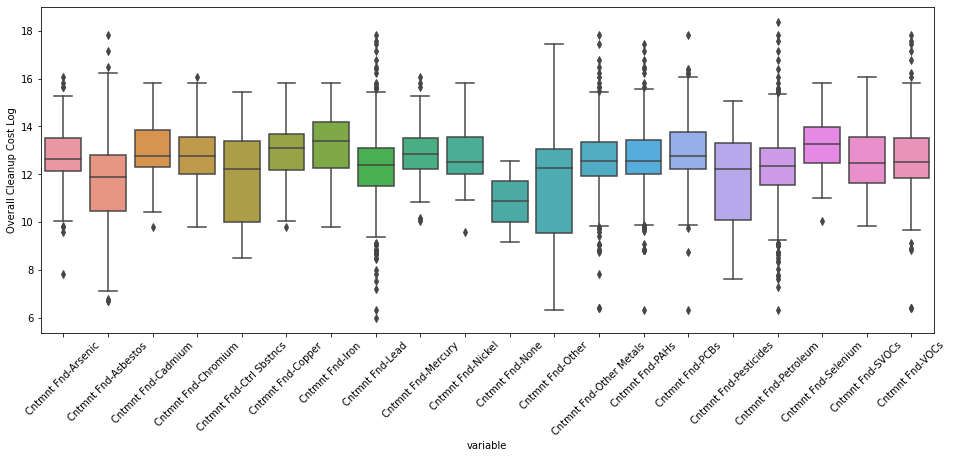

In [16]:
# differences in cost based on WHAT contaminents were found, not surprisingly
# some are more varied than others

plt.figure(figsize=(16, 6))

cntmnt_cols = [c for c in funding_df if 'Cntmnt Fnd-' in c]
cont_fnd = pd.melt(funding_df, id_vars=['ACRES Property ID','Overall Cleanup Cost'], value_vars=cntmnt_cols)
cont_fnd = cont_fnd[cont_fnd['value']==1]
cont_fnd['Overall Cleanup Cost Log'] = np.log(cont_fnd['Overall Cleanup Cost'])
sns.boxplot(x='variable', y='Overall Cleanup Cost Log', data=cont_fnd)

t = plt.xticks(rotation = 45)

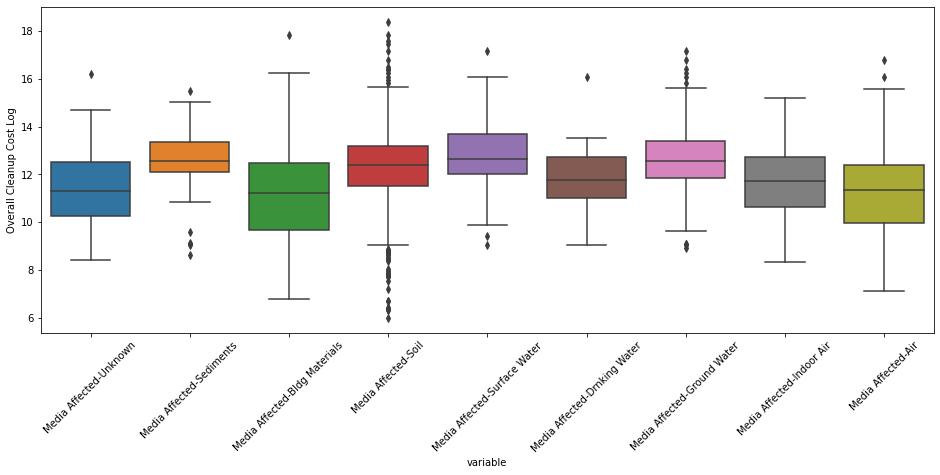

In [17]:
# differences in cost based on WHERE contaminents were found

plt.figure(figsize=(16, 6))

affected_cols = [c for c in funding_df if 'Media Affected-' in c]
affected_fnd = pd.melt(funding_df, id_vars=['ACRES Property ID','Overall Cleanup Cost'], value_vars=affected_cols)
affected_fnd = affected_fnd[affected_fnd['value']==1]
affected_fnd['Overall Cleanup Cost Log'] = np.log(affected_fnd['Overall Cleanup Cost'])
sns.boxplot(x='variable', y='Overall Cleanup Cost Log', data=affected_fnd)

t = plt.xticks(rotation = 45)

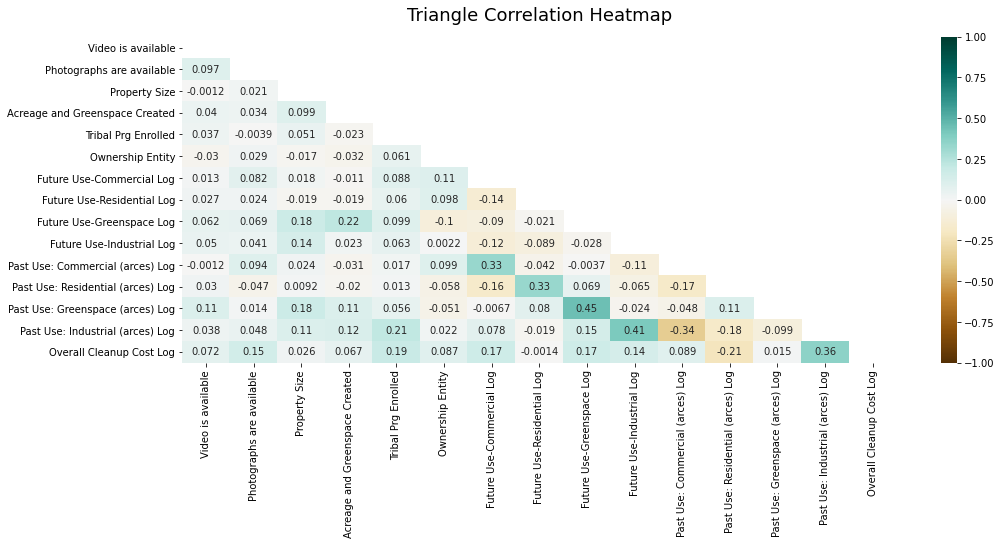

In [116]:
# correlation heatmap between some characteristics of the site and log of overall cost
# scatter plot indicates positive corr between past and future residential use but for
    # some reason it's showing up as neg corr here. Maybe because of the last # of 0's


plt.figure(figsize=(16, 6))

f = [c for c in model_df if 'Cntmnt' not in c and 'Affected' not in c and 'DP' not in c]
df = model_df[f]
mask = np.triu(np.ones_like(df.corr(), dtype=np.bool))
heatmap = sns.heatmap(df.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Triangle Correlation Heatmap', fontdict={'fontsize':18}, pad=16);

Text(0, 0.5, 'Overall Cleanup Cost Log')

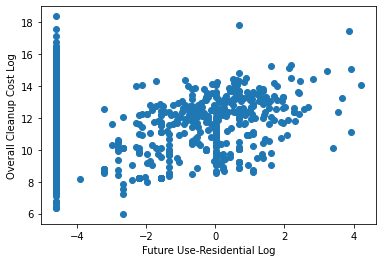

In [19]:
# Looks like larger residential size for future use -> higher cost
# though we do have a lot of 0's, might be causing it to not show up in the corr heatmap
plt.scatter(model_df['Future Use-Residential Log'], model_df['Overall Cleanup Cost Log'])
plt.xlabel('Future Use-Residential Log')
plt.ylabel('Overall Cleanup Cost Log')

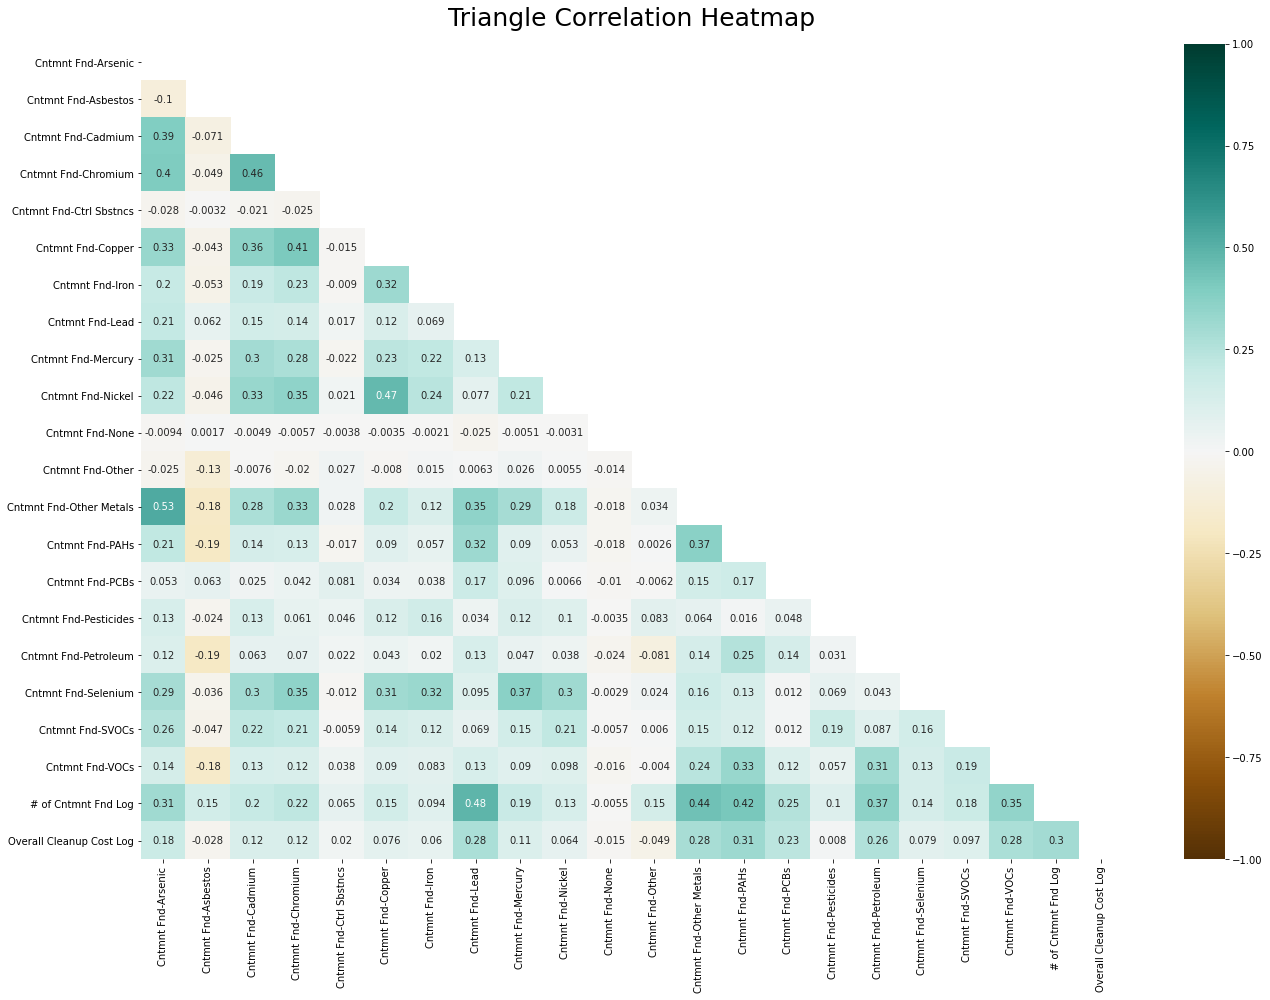

In [20]:
# correlation heatmap between what contaminant was found and log of overall cost
# higher number of contaminants found, higher cost

plt.figure(figsize=(22, 15))

f = [c for c in model_df if 'Cntmnt' in c] + ['Overall Cleanup Cost Log']
df = model_df[f]
mask = np.triu(np.ones_like(df.corr(), dtype=np.bool))
heatmap = sns.heatmap(df.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Triangle Correlation Heatmap', fontdict={'fontsize':25}, pad=18);

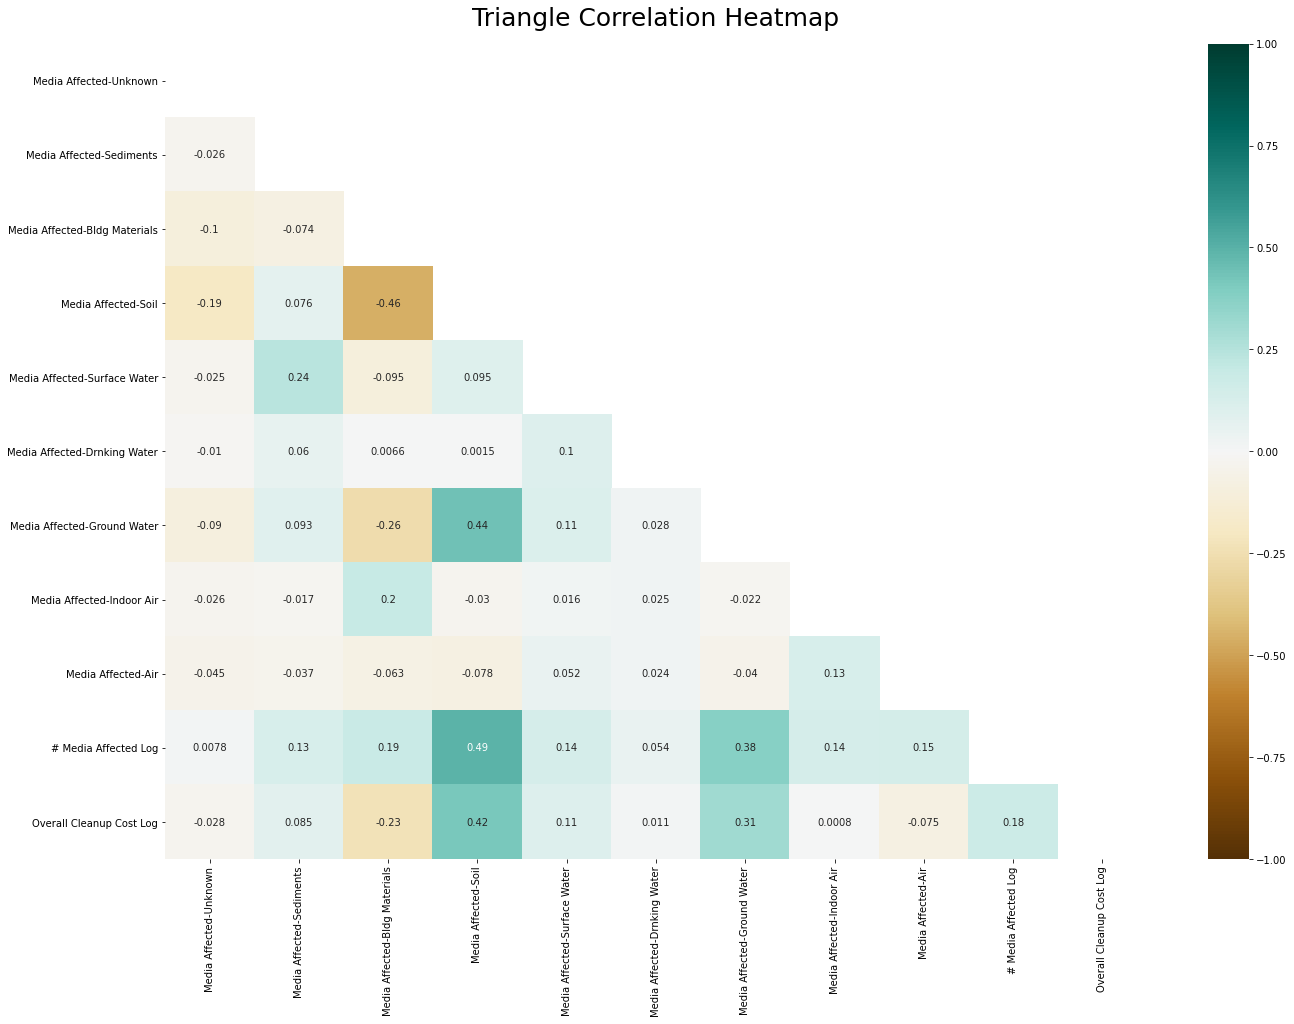

In [21]:
# correlation heatmap between where contaminant was found log of overall cost
# seems like negative correlation between cost and if cntmnt was found in building materials
# and strongest positive correlation if cntmnt was found in soil

plt.figure(figsize=(22, 15))

f = [c for c in model_df if 'Affected' in c] + ['Overall Cleanup Cost Log']
df = model_df[f]
mask = np.triu(np.ones_like(df.corr(), dtype=np.bool))
heatmap = sns.heatmap(df.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Triangle Correlation Heatmap', fontdict={'fontsize':25}, pad=18);

<AxesSubplot:xlabel='Media Affected-Bldg Materials', ylabel='Overall Cleanup Cost Log'>

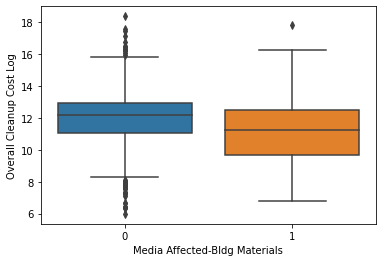

In [22]:
# seems like negative correlation between cost and if cntmnt was found in building materials
sns.boxplot(x='Media Affected-Bldg Materials', y = 'Overall Cleanup Cost Log', data=model_df)

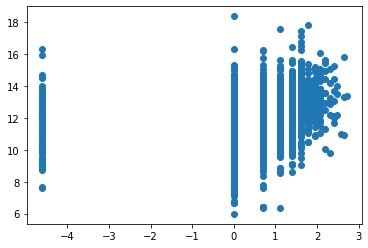

In [23]:
plt.scatter(model_df['# of Cntmnt Fnd Log'], model_df['Overall Cleanup Cost Log'])

<AxesSubplot:xlabel='Tribal Prg Enrolled', ylabel='Overall Cleanup Cost Log'>

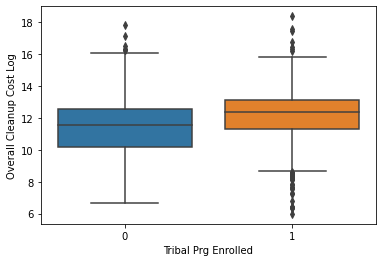

In [24]:
sns.boxplot(x='Tribal Prg Enrolled', y = 'Overall Cleanup Cost Log', data=model_df)

<AxesSubplot:xlabel='Photographs are available', ylabel='Overall Cleanup Cost Log'>

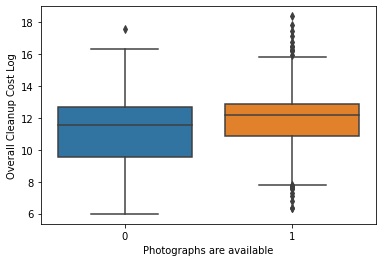

In [25]:
sns.boxplot(x='Photographs are available', y = 'Overall Cleanup Cost Log', data=model_df)

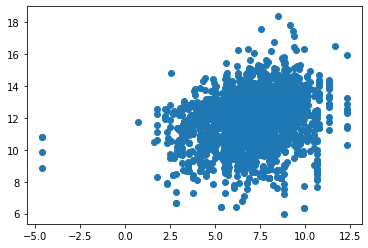

In [205]:
# most acs features seem to have pretty weak correlation with log of overall cost
# This is one of the few features with somewhat positive corr
# corresponds to total housing units
plt.scatter(model_df['DP04_0028E Log'], model_df['Overall Cleanup Cost Log'])

In [767]:
import plotly.graph_objects as go

df = funding_df.copy()
# normalize a bit
df['Overall Cleanup Cost'] = np.log(df['Overall Cleanup Cost'])

scl = [0,"rgb(150,0,90)"],[0.125,"rgb(0, 0, 200)"],[0.25,"rgb(0, 25, 255)"],\
[0.375,"rgb(0, 152, 255)"],[0.5,"rgb(44, 255, 150)"],[0.625,"rgb(151, 255, 0)"],\
[0.75,"rgb(255, 234, 0)"],[0.875,"rgb(255, 111, 0)"],[1,"rgb(255, 0, 0)"]

fig = go.Figure(data=go.Scattergeo(
    lat = df['Property Latitude'],
    lon = df['Property Longitude'],
    text = df['ACRES Property ID'],
    marker = dict(
        color = df['Overall Cleanup Cost'],
        colorscale = scl,
        reversescale = True,
        opacity = 0.7,
        size = 2,
        cmin = 0,
        cmax = df['Overall Cleanup Cost'].max(),
        colorbar_title="Log of Overall Cleanup Cost"
    )
))

fig.update_layout(
    geo = dict(
        scope = 'usa',
        showland = True,
        landcolor = "rgb(212, 212, 212)",
        subunitcolor = "rgb(255, 255, 255)",
        countrycolor = "rgb(255, 255, 255)",
        showlakes = False,
        lakecolor = "rgb(255, 255, 255)",
        showsubunits = True,
        showcountries = True,
        resolution = 50,
        projection = dict(
            type = 'conic conformal',
            rotation_lon = -100
        ),
        projection_type='albers usa',
        lonaxis = dict(
            showgrid = True,
            gridwidth = 0.5,
            range= [ -140.0, -55.0 ],
            dtick = 5
        ),
        lataxis = dict (
            showgrid = True,
            gridwidth = 0.5,
            range= [ 20.0, 60.0 ],
            dtick = 5
        )
    )
)
fig.show()

# Linear Regression

In [28]:
import statsmodels.api as sm

In [202]:
target = 'Overall Cleanup Cost Log'
Y = model_df[target]
X = model_df[[c for c in model_df if c != target]]
X = sm.add_constant(X)
model = sm.OLS(Y,X)
results = model.fit()

In [204]:
# need to do some feature selection + pca
# most of the acs features seem to be useless
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                               
====================================================================================
Dep. Variable:     Overall Cleanup Cost Log   R-squared:                       0.648
Model:                                  OLS   Adj. R-squared:                  0.547
Method:                       Least Squares   F-statistic:                     6.426
Date:                      Sat, 06 Mar 2021   Prob (F-statistic):          7.39e-188
Time:                              16:52:49   Log-Likelihood:                -3284.7
No. Observations:                      2259   AIC:                             7575.
Df Residuals:                          1756   BIC:                         1.045e+04
Df Model:                               502                                         
Covariance Type:                  nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const                              2004.2128   1149.361      1.744      0.081    -250.048    4258.473
Video is available                    0.3608      0.154      2.337      0.020       0.058       0.664
Photographs are available             0.0462      0.076      0.609      0.542      -0.102       0.195
Property Size                        -0.0003      0.001     -0.612      0.541      -0.001       0.001
Acreage and Greenspace Created        0.0059      0.005      1.121      0.262      -0.004       0.016
Tribal Prg Enrolled                   0.1531      0.070      2.183      0.029       0.016       0.291
Ownership Entity                     -0.0132      0.066     -0.201      0.841      -0.142       0.116
Cntmnt Fnd-Arsenic                    0.2566      0.131      1.954      0.051      -0.001       0.514
Cntmnt Fnd-Asbestos                   0.4438      0.087      5.096      0.000       0.273       0.615
Cntmnt Fnd-Cadmium                    0.1728      0.218      0.794      0.428      -0.254       0.600
Cntmnt Fnd-Chromium                  -0.1135      0.190     -0.597      0.551      -0.486       0.259
Cntmnt Fnd-Ctrl Sbstncs              -0.1617      0.247     -0.655      0.513      -0.646       0.323
Cntmnt Fnd-Copper                    -0.2110      0.315     -0.669      0.503      -0.829       0.407
Cntmnt Fnd-Iron                       0.9791      0.522      1.877      0.061      -0.044       2.002
Cntmnt Fnd-Lead                       0.1850      0.072      2.576      0.010       0.044       0.326
Cntmnt Fnd-Mercury                    0.0810      0.194      0.417      0.677      -0.300       0.462
Cntmnt Fnd-Nickel                    -0.2797      0.327     -0.856      0.392      -0.920       0.361
Cntmnt Fnd-None                      -0.3407      0.900     -0.379      0.705      -2.106       1.424
Cntmnt Fnd-Other                      0.3367      0.086      3.904      0.000       0.168       0.506
Cntmnt Fnd-Other Metals               0.0860      0.093      0.921      0.357      -0.097       0.269
Cntmnt Fnd-PAHs                       0.2905      0.082      3.554      0.000       0.130       0.451
Cntmnt Fnd-PCBs                       0.4755      0.099      4.819      0.000       0.282       0.669
Cntmnt Fnd-Pesticides                -0.2195      0.282     -0.778      0.437      -0.773       0.334
Cntmnt Fnd-Petroleum                 -0.0656      0.077     -0.856      0.392      -0.216       0.085
Cntmnt Fnd-Selenium                  -0.7527      0.344     -2.185      0.029      -1.428      -0.077
Cntmnt Fnd-SVOCs                      0.0693      0.176      0.393      0.695      -0.277       0.415
Cntmnt Fnd-VOCs                       0.1543      0.086    